In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
crema = "/kaggle/input/cremad/AudioWAV/"

In [3]:
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df['Path'])

0       /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1       /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2       /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3       /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4       /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
                              ...                        
7437    /kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav
7438    /kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav
7439    /kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav
7440    /kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav
7441    /kaggle/input/cremad/AudioWAV/1009_ITH_SAD_XX.wav
Name: Path, Length: 7442, dtype: object


In [4]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


2024-05-03 17:53:07.713765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 17:53:07.713920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 17:53:07.888894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import sys
import glob, pickle
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
emotions={
  '01':'neutral',
  '02':'pleasant',
  '03':'happiness',
  '04':'sadness',
  '05':'anger',
  '06':'fear',
  '07':'disgust',
  '08':'surprise'
}

In [7]:
#Emotions to observe
observed_emotions=['neutral','ps', 'happy', 'sad', 'angry', 'fear', 'disgust']

In [8]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [9]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input/toronto-emotional-speech-set-tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
#     if len(paths) == 2800:
#         break

print('Dataset is Loaded')
# data_dict = {
#     'Path': paths,  # Column for file paths
#     'Label': labels  # Column for labels
# }
# import pandas as pd  # Ensure Pandas is imported

# # Create a DataFrame from the dictionary
# tess_df = pd.DataFrame(data_dict)
# print(tess_df.head())  # Displays the first 5 rows

# # Display the DataFrame's shape to see how many rows and columns it has
# print("DataFrame shape:", tess_df.shape)

Dataset is Loaded


In [10]:
def load_data(test_size=0.2):
    # Initialize lists for features and labels
    x = []  # Features
    y = []  # Labels

    # Extract features and labels from predefined lists
    for path, label in zip(paths, labels):
        if label not in observed_emotions:
            continue  # Skip if the label is not in the observed emotions
        feature = extract_mfcc(path)  # Pass the full file path
        x.append(feature)  # Add extracted features to the list
        y.append(label)   # Add label to the list
    
#     # Extract features and labels from Crema_df
#     for row in Crema_df.itertuples(index=False, name=None):
#         Path, Emotions = row  # Explicit unpacking
#         feature = extract_mfcc(Path)  # Pass the full file path
#         x.append(feature)  # Add extracted features to the list
#         y.append(Emotions)  # Add label to the list

#     # Return the extracted features and labels
    return {"X": x, "y": y}


In [11]:

import time
start_time=time.time()
Trail_dict = load_data(test_size=0.2)
X = pd.DataFrame(Trail_dict["X"])
y = pd.DataFrame(Trail_dict["y"])
data = pd.concat([X,y],join='outer',axis=1)
data.columns=['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8','feature9','feature10','feature11',
             'feature12','feature13','feature14','feature15','feature16','feature17','feature18','feature19','feature20','feature21','feature22',
              'feature23',
             'feature24','feature25','feature26','feature27','feature28','feature29','feature30','feature31','feature32',
              'feature33','feature34','feature35','feature36','feature37','feature38','feature39','feature40','emotion'
             ]
data['label']=data['emotion'].astype('object')
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['label']=le.fit_transform(data['label'])
data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,emotion,label
0,-285.737274,85.782951,-2.168912,22.125530,-14.757398,11.051346,12.412449,-3.000262,1.084499,11.078273,...,-11.202218,-9.024621,-3.666985,4.869744,-1.602798,2.560051,11.454374,11.233451,fear,2
1,-348.343323,35.193233,-3.841328,14.658875,6.421053,-0.773787,-4.091444,-7.512503,-20.121277,1.180449,...,-1.774828,-7.043899,-12.571158,3.316836,1.701795,-0.645632,0.335101,9.383598,fear,2
2,-340.114349,53.796444,-14.267782,20.884027,9.057836,-3.562478,-3.301548,-11.213589,-5.353901,4.443878,...,-15.309781,-6.463319,-4.059399,4.893753,-0.165810,2.755698,11.734241,11.355121,fear,2
3,-306.634216,21.259708,-4.411082,6.487155,-7.804567,9.876858,-1.674363,-13.998476,-9.832037,15.141318,...,-8.218043,-0.909134,0.446974,5.390133,-1.845823,3.844763,0.011730,-0.432099,fear,2
4,-344.754791,46.329193,-24.171413,19.392921,2.262577,-6.460284,-5.930691,5.036542,-3.744801,4.203501,...,-4.668800,6.438029,-2.390229,0.041108,1.869342,1.520124,-0.805184,-2.195965,fear,2


In [12]:
#SPLITTING DATASET (TRAINING AND TESTING)

from sklearn.model_selection import train_test_split

#Split train & test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (4480, 40)
y_train shape: (4480, 1)
X_test shape: (1120, 40)
y_test shape: (1120, 1)


In [13]:
print(y_test)

            0
4795       ps
4269  disgust
2004    happy
2515      sad
3014    angry
...       ...
657   disgust
3260     fear
4294  disgust
4041      sad
4118      sad

[1120 rows x 1 columns]


In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

#Encode emotion labels into numbers
y_train_lb = to_categorical(lb.fit_transform(y_train))
y_test_lb = to_categorical(lb.fit_transform(y_test))

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train_lb.shape}')
print(y_train_lb)
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test_lb.shape}')

X_train shape: (4480, 40)
y_train shape: (4480, 7)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]
X_test shape: (1120, 40)
y_test shape: (1120, 7)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
#Check encoding
np.unique(y_train_lb, axis=0)


#Check encoding labels
print(lb.classes_)


['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


In [16]:
#Building new lists of encoding labels
y_labels_encoded = {}
for i, label in enumerate(lb.classes_):
    y_labels_encoded[i] = label
    
print(y_labels_encoded)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'ps', 6: 'sad'}


In [17]:
from sklearn.preprocessing import StandardScaler
#SCALING THE DATA
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

In [18]:
#Adding dimension for CNN
x_traincnn = np.expand_dims(X_train_scalled, axis=2)
x_testcnn = np.expand_dims(X_test_scalled, axis=2)

#Checking shapes of dataframes
print(x_traincnn.shape)
print(x_testcnn.shape)

(4480, 40, 1)
(1120, 40, 1)


In [19]:
#Importing packages for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D 
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten, MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint




#BUILDING CNN MODEL
CNN_model = Sequential()

In [20]:
#Build first layer
CNN_model.add(Conv1D(16, 5,padding='same',
                 input_shape=(40, 1), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(MaxPooling1D(pool_size=(2)))

#Build second layer
CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(MaxPooling1D(pool_size=(2)))
#Build third layer
CNN_model.add(Conv1D(64, 5,padding='same',activation='relu'))
CNN_model.add(Dropout(0.3))
CNN_model.add(MaxPooling1D(pool_size=(2)))
#Build forth layer
CNN_model.add(Conv1D(128, 5,padding='same',activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(MaxPooling1D(pool_size=(2)))
#Add dropout
CNN_model.add(Dropout(0.3))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [21]:

#Flatten 
CNN_model.add(Flatten())

CNN_model.add(Dense(128, activation ='relu'))
CNN_model.add(Dropout(0.1))
CNN_model.add(Dense(64, activation ='relu'))
CNN_model.add(Dense(7, activation='softmax'))
# CNN model summary
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 16)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 32)         │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 128)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,687 (373.78 KB)

 Trainable params: 95,687 (373.78 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:

# COMPILING THE MODEL 
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [23]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.keras', 
                               verbose=1, save_best_only=True)


In [24]:
#MODEL FIT
cnn_results = CNN_model.fit(x_traincnn, y_train_lb,
              batch_size = 64,
              epochs = 25,
              verbose = 1,
              validation_data = (x_testcnn, y_test_lb))

Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3198 - loss: 1.6584 - val_accuracy: 0.8848 - val_loss: 0.5402
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8304 - loss: 0.4771 - val_accuracy: 0.9250 - val_loss: 0.2641
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9037 - loss: 0.2856 - val_accuracy: 0.9563 - val_loss: 0.1646
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9320 - loss: 0.1908 - val_accuracy: 0.9714 - val_loss: 0.1215
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9328 - loss: 0.1828 - val_accuracy: 0.9750 - val_loss: 0.1025
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9540 - loss: 0.1416 - val_accuracy: 0.9795 - val_loss: 0.0915
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9627 - loss: 0.1127 - val_accuracy: 0.9786 - val_loss: 0.0846
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9637 - loss: 0.1168 - val_accuracy: 0.9812 - v

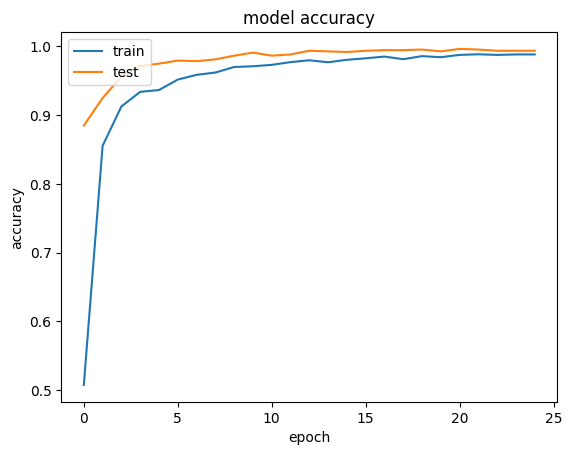

In [25]:

#Ploting model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:

# Evaluating the model on the training and testing set
score = CNN_model.evaluate(x_traincnn, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9993303418159485
Testing Accuracy:  0.9937499761581421


In [27]:
#Get predictions from model
y_test_predictions = CNN_model.predict(x_testcnn)
y_test_labels = np.argmax(y_test_predictions, axis=-1)
print(y_test_labels)


#Get labels for emotions
print(y_labels_encoded)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[5 1 3 ... 1 6 6]
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'ps', 6: 'sad'}


In [28]:
print(y_test)

            0
4795       ps
4269  disgust
2004    happy
2515      sad
3014    angry
...       ...
657   disgust
3260     fear
4294  disgust
4041      sad
4118      sad

[1120 rows x 1 columns]


In [29]:
label_to_index = {v: k for k, v in y_labels_encoded.items()}

In [30]:
y_test_numeric = np.array([label_to_index[label] for label in y_test[0]])

print("Numeric indices for y_test:", y_test_numeric)

Numeric indices for y_test: [5 1 3 ... 1 6 6]


[[168   0   2   0   0   0   0]
 [  0 169   0   0   0   0   0]
 [  0   0 157   0   0   0   0]
 [  0   0   0 155   0   3   0]
 [  0   0   0   0 157   0   0]
 [  0   0   0   2   0 159   0]
 [  0   0   0   0   0   0 148]]
The rows represents the true values or observations
The columns respresent the model's predictions
         angry  disgust  fear  happy  neutral   ps  sad
angry      168        0     2      0        0    0    0
disgust      0      169     0      0        0    0    0
fear         0        0   157      0        0    0    0
happy        0        0     0    155        0    3    0
neutral      0        0     0      0      157    0    0
ps           0        0     0      2        0  159    0
sad          0        0     0      0        0    0  148


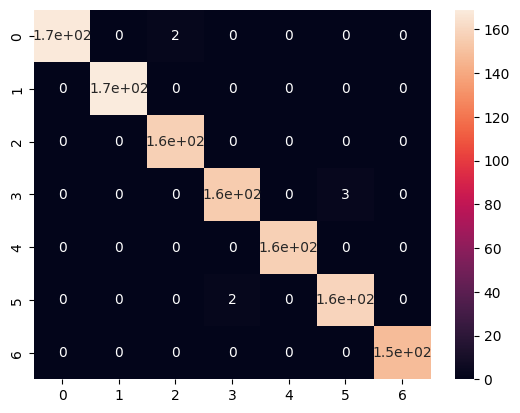

In [31]:


from sklearn.metrics import confusion_matrix

#BUILDING CONFUSION MATRIX 
confusion_matrix = confusion_matrix(y_test_numeric,y_test_labels)
print(confusion_matrix)


#PLOTTING HEAT MAP
ax = sns.heatmap(confusion_matrix, annot=True)



#Adding labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, columns=list(y_labels_encoded.values()), index=list(y_labels_encoded.values()))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")
print(confusion_matrix)